In [1]:
## import library for serial communication 
## main.py and picoserial.py moved to directory
import picoserial
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from picoscope import ps2000

In [3]:
from scipy.optimize import curve_fit
from time import sleep
import pandas as pd

# Section 1 - Test out motor and scope

## 1.1 - Motor

In [4]:
## instance of class
motor =  picoserial.PicoSerial()

In [5]:
## prepare motor to go
motor.send("initialise()")
print(motor.receive())            
print(motor.receive_reply(1000))

Initialising
Initialised


In [14]:
## send command to motor and read it's reply
motor.send("move(100000)")
motor.receive()

'Moving'

In [117]:
## move back to 0 position
motor.send("initialise()")
print(motor.receive_reply(1000))

Initialising


In [6]:
motor.receive()

'Initialised'

## 1.2 - Setting up Scope

In [6]:
ps = ps2000.PS2000()

In [7]:
## set sampling parameters
waveform_desired_duration = 50e-6
obs_duration = 3 * waveform_desired_duration    #range 
sampling_interval = obs_duration / 4096         #sampling interval

In [8]:
(actualSamplingInterval, nSamples, maxSamples) = ps.setSamplingInterval(sampling_interval, obs_duration)

In [9]:
## set up channels
ps.setChannel('A', 'DC', 10.0, 0.0, enabled=True,BWLimited=False)
ps.setChannel('B', 'DC', 10.0, 0.0, enabled=True,BWLimited=False)

10.0

In [10]:
## channel A acts as trigger
ps.setSimpleTrigger('A', 1.0, 'Falling', timeout_ms=100, enabled=True) 

In [11]:
ps.runBlock()
ps.waitReady()

## 'harvest' data
dataA = ps.getDataV('A', nSamples, returnOverflow=False)     
dataB = ps.getDataV('B', nSamples, returnOverflow=False)

In [12]:
## time axis
dataTimeAxis = np.arange(nSamples) * actualSamplingInterval

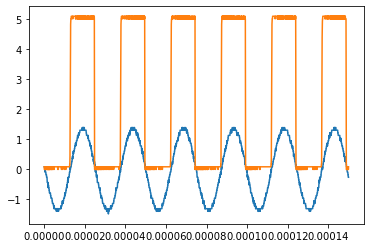

In [13]:
## plot scope data
plt.plot(dataTimeAxis,dataB)
plt.plot(dataTimeAxis,dataA)     ## A is trigger

# Section 2 - Take some data

## 2.1 - Extract Phase and Amplitude

In [14]:
def sin_func(x,A,c):
    
    return A*np.sin(2*np.pi*40000*(x)+c)

-1.3467241041222433 0.04094544306589583


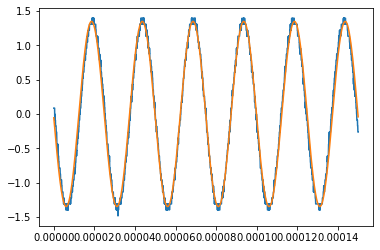

In [15]:
plt.plot(dataTimeAxis,dataB)

popt,cov = curve_fit(sin_func,dataTimeAxis,dataB,p0=[1,0])

amp = popt[0]
phase = popt[1]
print(amp,phase)
plt.plot(dataTimeAxis,sin_func(dataTimeAxis,amp,phase))

In [16]:
## functionalise fitting
def fit_for_phase_amp(x,y,guess_phase):
    
    popt,cov = curve_fit(sin_func,x,y,p0=[1,guess_phase])
    Amp = popt[0]
    Phase = popt[1]
    return Amp, Phase

In [17]:
## loop to move motor x steps and record phase and amp at each step by fitting
## 10 data points taken and averaged over at each step

In [18]:
def move_motor(number_steps):

    list_amps = []
    list_phases = [0]
    err_A = []
    err_P = []

    for i in np.arange(1,number_steps,1):
        x= 200000/number_steps
        
        motor.send("move("+str(x)+")")
        sleep(0.5)
        motor.send("get_current_pos()")
        #sleep(0.1)
        position = motor.receive()
        #print(int(x*i))
        print(float((position)))

        if int(x*i) == round(float(position),1):
            #print('yay')
            amps_to_avg = []
            phases_to_avg = []

            for n in np.arange(0,40,1):
                ps.runBlock()
                ps.waitReady()
                dataB = ps.getDataV('B', nSamples, returnOverflow=False)
                
                try:
                    A,P = fit_for_phase_amp(dataTimeAxis,dataB,guess_phase=list_phases[i-1])
                    amps_to_avg.append(np.abs(A))
                    phases_to_avg.append(P)
                except:
                    A,P = fit_for_phase_amp(dataTimeAxis,dataB,guess_phase=list_phases[i-2])
                    amps_to_avg.append(np.abs(A))
                    phases_to_avg.append(P)

            mean_A = np.mean(amps_to_avg)
            mean_p = np.mean(phases_to_avg)

            err_As = np.std(amps_to_avg)
            err_Ps = np.std(phases_to_avg)

            list_amps.append(mean_A)
            list_phases.append(mean_p)
            
            err_A.append(list_amps)
            err_P.append(list_phases)
            
    return list_amps,list_phases,err_A,err_P

## Section 2.2 - Measure Background

In [56]:
## move back to 0 position
motor.send("initialise()")
print(motor.receive_reply(1000))

Initialising


<ErrorbarContainer object of 3 artists>

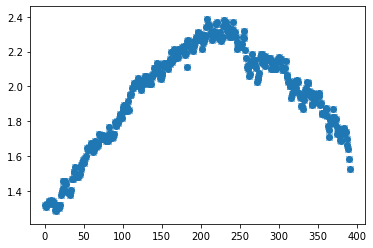

In [139]:
plt.scatter(x,list_amps)
plt.errorbar(x,list_amps,yerr=err_A,fmt='x')

In [137]:
len(list_amps)

391

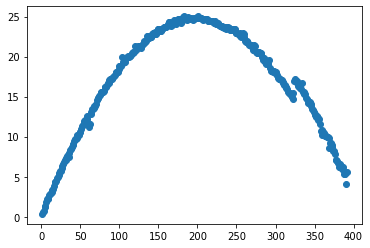

In [138]:
plt.scatter(np.arange(1,len(list_phases)+1,1),np.unwrap(list_phases,period=np.pi))
#plt.errorbar(x,np.unwrap(list_phases,period=np.pi),yerr=err_P,fmt='x',color='r')

In [145]:
## unwrap phases - repeating every pi (not 2pi)
#np.unwrap(list_phases,period=np.pi)

In [26]:
Amps1,Phases1,errA1,errP1 = move_motor(200)

1000.0
1000.0
1000.0
2000.0
1000.0
3000.0
1000.0
4000.0
1000.0
5000.0
1000.0
6000.0
1000.0
7000.0
1000.0
8000.0
1000.0
9000.0
1000.0
10000.0
1000.0
11000.0
1000.0
12000.0
1000.0
13000.0
1000.0
14000.0
1000.0
15000.0
1000.0
16000.0
1000.0
17000.0
1000.0
18000.0
1000.0
19000.0
1000.0
20000.0
1000.0
21000.0
1000.0
22000.0
1000.0
23000.0
1000.0
24000.0
1000.0
25000.0
1000.0
26000.0
1000.0
27000.0
1000.0
28000.0
1000.0
29000.0
1000.0
30000.0
1000.0
31000.0
1000.0
32000.0
1000.0
33000.0
1000.0
34000.0
1000.0
35000.0
1000.0
36000.0
1000.0
37000.0
1000.0
38000.0
1000.0
39000.0
1000.0
40000.0
1000.0
41000.0
1000.0
42000.0
1000.0
43000.0
1000.0
44000.0
1000.0
45000.0
1000.0
46000.0
1000.0
47000.0
1000.0
48000.0
1000.0
49000.0
1000.0
50000.0
1000.0
51000.0
1000.0
52000.0
1000.0
53000.0
1000.0
54000.0
1000.0
55000.0
1000.0
56000.0
1000.0
57000.0
1000.0
58000.0
1000.0
59000.0
1000.0
60000.0
1000.0
61000.0
1000.0
62000.0
1000.0
63000.0
1000.0
64000.0
1000.0
65000.0
1000.0
66000.0
1000.0
67000.0
1000

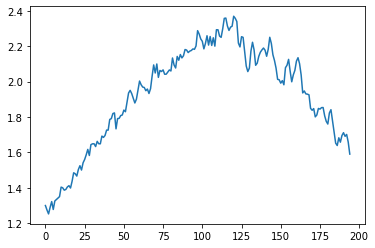

In [27]:
plt.plot(Amps1)

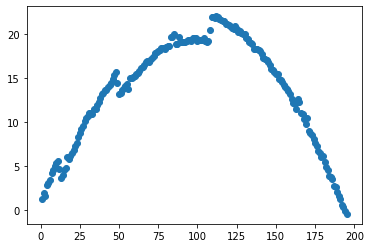

In [29]:
plt.scatter(np.arange(1,len(Phases1)+1,1),np.unwrap(Phases1,period=np.pi))

In [34]:
Amps2,Phases2,errA2,errP2 = move_motor(400)

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [72]:
directory = r"C:\Users\Student\Documents\Student\Data"

In [83]:
run2 = dict(amp = Amps2,phase =Phases2,errA =errA2,errP = errP2 )
# Create DataFrame from Dictionary
run2_df= pd.DataFrame.from_dict(run2)
#export to csv format
run2_df.to_csv(directory+'/run2_bg.csv',index = False)

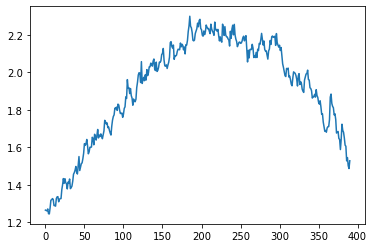

In [60]:
plt.plot(Amps2)

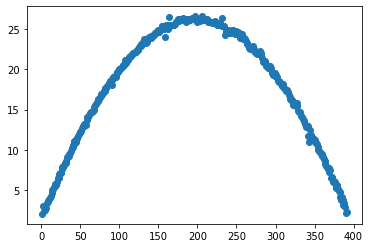

In [36]:
plt.scatter(np.arange(1,len(Phases2)+1,1),np.unwrap(Phases2,period=np.pi))

In [52]:
Amps3,Phases3,errA3,errP3 = move_motor(400)

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

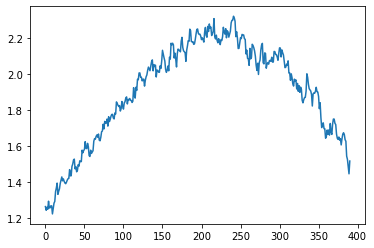

In [54]:
plt.plot(Amps3)

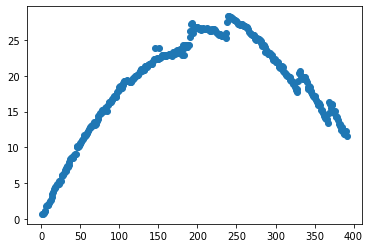

In [61]:
plt.scatter(np.arange(1,len(Phases3)+1,1),np.unwrap(Phases3,period=np.pi))

In [65]:
Amps4,Phases4,errA4,errP4 = move_motor(400)

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

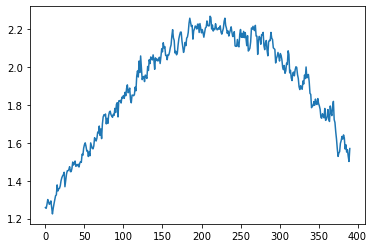

In [66]:
plt.plot(Amps4)

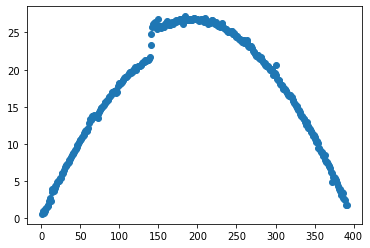

In [67]:
plt.scatter(np.arange(1,len(Phases4)+1,1),np.unwrap(Phases4,period=np.pi))

In [79]:
run1 = dict(amp = Amps1,phase =Phases1,errA =errA1,errP = errP1 )
# Create DataFrame from Dictionary
run1_df= pd.DataFrame.from_dict(run1)
#export to csv format
run1_df.to_csv(directory+'/run1_bg.csv',index = False)

In [74]:
run3 = dict(amp = Amps3,phase =Phases3,errA =errA3,errP = errP3 )
# Create DataFrame from Dictionary
run3_df= pd.DataFrame.from_dict(run3)
#export to csv format
run3_df.to_csv(directory+'/run3_bg.csv',index = False)

In [75]:
run4 = dict(amp = Amps4,phase =Phases4,errA =errA4,errP = errP4 )
# Create DataFrame from Dictionary
run4_df= pd.DataFrame.from_dict(run4)
#export to csv format
run4_df.to_csv(directory+'/run4_bg.csv',index = False)

In [80]:
Amps5,Phases5,errA5,errP5 = move_motor(400)

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

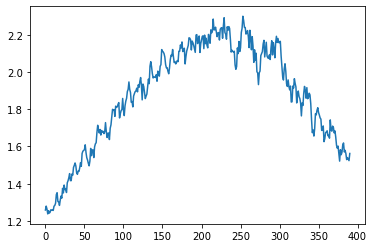

In [81]:
plt.plot(Amps5)

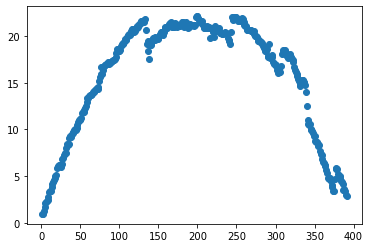

In [82]:
plt.scatter(np.arange(1,len(Phases5)+1,1),np.unwrap(Phases5,period=np.pi))

In [84]:
run5 = dict(amp = Amps5,phase =Phases5,errA =errA5,errP = errP5 )
# Create DataFrame from Dictionary
run5_df= pd.DataFrame.from_dict(run5)
#export to csv format
run5_df.to_csv(directory+'/run5_bg.csv',index = False)

## Section 2.3 - Straight edge

In [72]:
directory_se = r'C:\Users\Student\Documents\Student\straight_edge'

In [88]:
Amps_se1,Phasesse1,errAse1,errPse1 = move_motor(400)

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

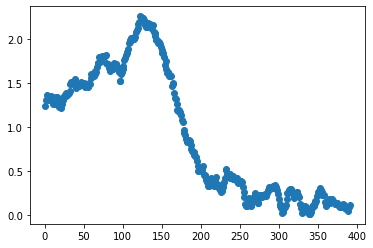

In [98]:
plt.scatter(np.arange(1,392,1),np.array(Amps_se1))

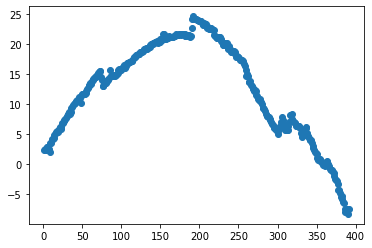

In [91]:
plt.scatter(np.arange(1,len(Phasesse1)+1,1),np.unwrap(Phasesse1,period=np.pi))

In [95]:
Amps_se2,Phasesse2,errAse2,errPse2 = move_motor(400)

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

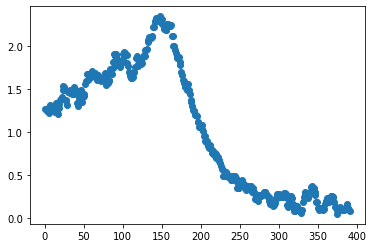

In [99]:
plt.scatter(np.arange(1,392,1),Amps_se2)

In [105]:
runse1 = dict(amp = Amps_se1,phase =Phasesse1,errA =errAse1,errP = errPse1 )

runse1_df= pd.DataFrame.from_dict(runse1)
runse1_df.to_csv(directory_se+'/run_se1.csv',index = False)

In [104]:
runse2 = dict(amp = Amps_se2,phase =Phasesse2,errA =errAse2,errP = errPse2)

runse2_df= pd.DataFrame.from_dict(runse2)
runse2_df.to_csv(directory_se+'/run_se2.csv',index = False)

In [109]:
Ampsse3,Phasesse3,errAse3,errPse3 = move_motor(400)

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

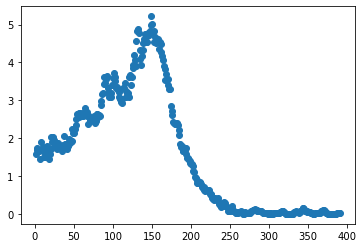

In [113]:
plt.scatter(np.arange(1,392,1),np.array(Ampsse3)**2)

In [114]:
runse3 = dict(amp = Ampsse3,phase =Phasesse3,errA =errAse3,errP = errPse3)

runse3_df= pd.DataFrame.from_dict(runse3)
runse3_df.to_csv(directory_se+'/run_se3.csv',index = False)

In [118]:
Ampsse4,Phasesse4,errAse4,errPse4 = move_motor(800)

250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4250.0
4500.0
4750.0
5000.0
5250.0
5500.0
5750.0
6000.0
6250.0
6500.0
6750.0
7000.0
7250.0
7500.0
7750.0
8000.0
8250.0
8500.0
8750.0
9000.0
9250.0
9500.0
9750.0
10000.0
10250.0
10500.0
10750.0
11000.0
11250.0
11500.0
11750.0
12000.0
12250.0
12500.0
12750.0
13000.0
13250.0
13500.0
13750.0
14000.0
14250.0
14500.0
14750.0
15000.0
15250.0
15500.0
15750.0
16000.0
16250.0
16500.0
16750.0
17000.0
17250.0
17500.0
17750.0
18000.0
18250.0
18500.0
18750.0
19000.0
19250.0
19500.0
19750.0
20000.0
20250.0
20500.0
20750.0
21000.0
21250.0
21500.0
21750.0
22000.0
22250.0
22500.0
22750.0
23000.0
23250.0
23500.0
23750.0
24000.0
24250.0
24500.0
24750.0
25000.0
25250.0
25500.0
25750.0
26000.0
26250.0
26500.0
26750.0
27000.0
27250.0
27500.0
27750.0
28000.0
28250.0
28500.0
28750.0
29000.0
29250.0
29500.0
29750.0
30000.0
30250.0
30500.0
30750.0
31000.0
31250.0
31500.0
31750.0
32000.0
32250.0
32500.0
32

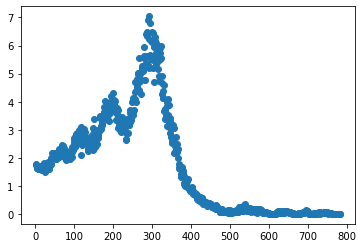

In [120]:
plt.scatter(np.arange(1,len(Ampsse4)+1,1),np.array(Ampsse4)**2)    ## d = 52.5cm ,, center of yoke = 31cm

In [121]:
runse4 = dict(amp = Ampsse4,phase =Phasesse4,errA =errAse4,errP = errPse4)

runse4_df= pd.DataFrame.from_dict(runse4)
runse4_df.to_csv(directory_se+'/run_se4.csv',index = False)

In [17]:
## retest straight edge

In [73]:
## move back to 0 position
motor.send("initialise()")
print(motor.receive_reply(1000))

Initialising


In [69]:
Ampsse1,Phasesse1,errAse1,errPse1 = move_motor(100)

2000
2000.0
4000
4000.0
6000
6000.0
8000
8000.0
10000
10000.0
12000
12000.0
14000
14000.0
16000
16000.0
18000
18000.0
20000
20000.0
22000
22000.0
24000
24000.0
26000
26000.0
28000
28000.0
30000
30000.0
32000
32000.0
34000
34000.0
36000
36000.0
38000
38000.0
40000
40000.0
42000
42000.0
44000
44000.0
46000
46000.0
48000
48000.0
50000
50000.0
52000
52000.0
54000
54000.0
56000
56000.0
58000
58000.0
60000
60000.0
62000
62000.0
64000
64000.0
66000
66000.0
68000
68000.0
70000
70000.0
72000
72000.0
74000
74000.0
76000
76000.0
78000
78000.0
80000
80000.0
82000
82000.0
84000
84000.0
86000
85999.99
88000
88000.0
90000
90000.0
92000
92000.0
94000
94000.0
96000
95999.99
98000
98000.0
100000
100000.0
102000
102000.0
104000
104000.0
106000
106000.0
108000
108000.0
110000
110000.0
112000
112000.0
114000
114000.0
116000
116000.0
118000
118000.0
120000
120000.0
122000
122000.0
124000
124000.0
126000
126000.0
128000
128000.0
130000
130000.0
132000
132000.0
134000
134000.0
136000
136000.0
138000
138000.0


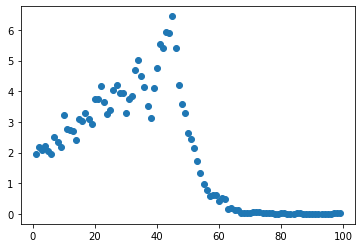

In [70]:
plt.scatter(np.arange(1,len(Ampsse1)+1,1),np.array(Ampsse1)**2)    ## d = 52.5cm 

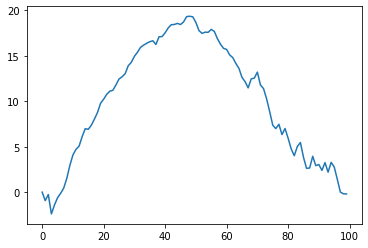

In [71]:
plt.plot(np.array(Phasesse1))   

In [86]:
#Phasesse1[1:]

In [87]:
test = dict(amp = Ampsse1,phase =Phasesse1[1:],errA =errAse1,errP = errPse1)

test_df= pd.DataFrame.from_dict(test)
test_df.to_csv(directory_se+'/test.csv',index = False)

In [126]:
Ampsse5,Phasesse5,errAse5,errPse5 = move_motor(800)

250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4250.0
4500.0
4750.0
5000.0
5250.0
5500.0
5750.0
6000.0
6250.0
6500.0
6750.0
7000.0
7250.0
7500.0
7750.0
8000.0
8250.0
8500.0
8750.0
9000.0
9250.0
9500.0
9750.0
10000.0
10250.0
10500.0
10750.0
11000.0
11250.0
11500.0
11750.0
12000.0
12250.0
12500.0
12750.0
13000.0
13250.0
13500.0
13750.0
14000.0
14250.0
14500.0
14750.0
15000.0
15250.0
15500.0
15750.0
16000.0
16250.0
16500.0
16750.0
17000.0
17250.0
17500.0
17750.0
18000.0
18250.0
18500.0
18750.0
19000.0
19250.0
19500.0
19750.0
20000.0
20250.0
20500.0
20750.0
21000.0
21250.0
21500.0
21750.0
22000.0
22250.0
22500.0
22750.0
23000.0
23250.0
23500.0
23750.0
24000.0
24250.0
24500.0
24750.0
25000.0
25250.0
25500.0
25750.0
26000.0
26250.0
26500.0
26750.0
27000.0
27250.0
27500.0
27750.0
28000.0
28250.0
28500.0
28750.0
29000.0
29250.0
29500.0
29750.0
30000.0
30250.0
30500.0
30750.0
31000.0
31250.0
31500.0
31750.0
32000.0
32250.0
32500.0
32

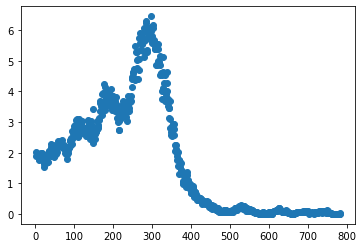

In [128]:
plt.scatter(np.arange(1,len(Ampsse5)+1,1),np.array(Ampsse5)**2)    ## d = 52.5cm ,, center of yoke = 31cm

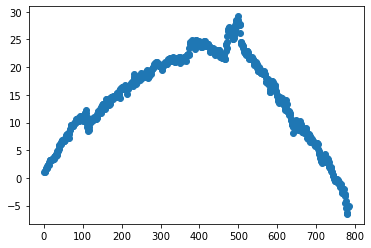

In [132]:
plt.scatter(np.arange(1,len(Phasesse5)+1,1),np.unwrap((Phasesse5),period=np.pi))  ## d = 52.5cm ,, center of yoke = 31cm

In [133]:
runse5 = dict(amp = Ampsse5,phase =Phasesse5,errA =errAse5,errP = errPse5)

runse5_df= pd.DataFrame.from_dict(runse5)
runse5_df.to_csv(directory_se+'/run_se5.csv',index = False)

In [138]:
Ampsse6,Phasesse6,errAse6,errPse6 = move_motor(800)

250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4250.0
4500.0
4750.0
5000.0
5250.0
5500.0
5750.0
6000.0
6250.0
6500.0
6750.0
7000.0
7250.0
7500.0
7750.0
8000.0
8250.0
8500.0
8750.0
9000.0
9250.0
9500.0
9750.0
10000.0
10250.0
10500.0
10750.0
11000.0
11250.0
11500.0
11750.0
12000.0
12250.0
12500.0
12750.0
13000.0
13250.0
13500.0
13750.0
14000.0
14250.0
14500.0
14750.0
15000.0
15250.0
15500.0
15750.0
16000.0
16250.0
16500.0
16750.0
17000.0
17250.0
17500.0
17750.0
18000.0
18250.0
18500.0
18750.0
19000.0
19250.0
19500.0
19750.0
20000.0
20250.0
20500.0
20750.0
21000.0
21250.0
21500.0
21750.0
22000.0
22250.0
22500.0
22750.0
23000.0
23250.0
23500.0
23750.0
24000.0
24250.0
24500.0
24750.0
25000.0
25250.0
25500.0
25750.0
26000.0
26250.0
26500.0
26750.0
27000.0
27250.0
27500.0
27750.0
28000.0
28250.0
28500.0
28750.0
29000.0
29250.0
29500.0
29750.0
30000.0
30250.0
30500.0
30750.0
31000.0
31250.0
31500.0
31750.0
32000.0
32250.0
32500.0
32

In [139]:
runse6 = dict(amp = Ampsse6,phase =Phasesse6,errA =errAse6,errP = errPse6)

runse6_df= pd.DataFrame.from_dict(runse6)
runse6_df.to_csv(directory_se+'/run_se6.csv',index = False)

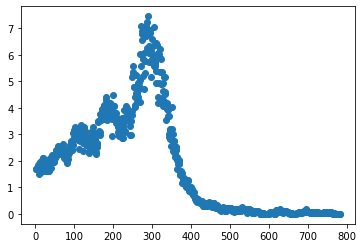

In [140]:
plt.scatter(np.arange(1,len(Ampsse6)+1,1),np.array(Ampsse6)**2)    ## d = 52.5cm ,, center of yoke = 31cm

In [19]:
Ampsse7,Phasesse7,errAse7,errPse7 = move_motor(800)  ## centre = 30cm, d=34cm 

250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4250.0
4500.0
4750.0
5000.0
5250.0
5500.0
5750.0
6000.0
6250.0
6500.0
6750.0
7000.0
7250.0
7500.0
7750.0
8000.0
8250.0
8500.0
8750.0
9000.0
9250.0
9500.0
9750.0
10000.0
10250.0
10500.0
10750.0
11000.0
11250.0
11500.0
11750.0
12000.0
12250.0
12500.0
12750.0
13000.0
13250.0
13500.0
13750.0
14000.0
14250.0
14500.0
14750.0
15000.0
15250.0
15500.0
15750.0
16000.0
16250.0
16500.0
16750.0
17000.0
17250.0
17500.0
17750.0
18000.0
18250.0
18500.0
18750.0
19000.0
19250.0
19500.0
19750.0
20000.0
20250.0
20500.0
20750.0
21000.0
21250.0
21500.0
21750.0
22000.0
22250.0
22500.0
22750.0
23000.0
23250.0
23500.0
23750.0
24000.0
24250.0
24500.0
24750.0
25000.0
25250.0
25500.0
25750.0
26000.0
26250.0
26500.0
26750.0
27000.0
27250.0
27500.0
27750.0
28000.0
28250.0
28500.0
28750.0
29000.0
29250.0
29500.0
29750.0
30000.0
30250.0
30500.0
30750.0
31000.0
31250.0
31500.0
31750.0
32000.0
32250.0
32500.0
32

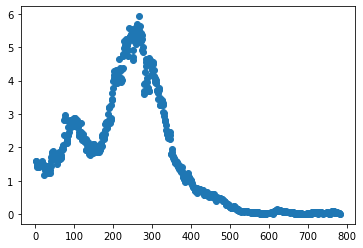

In [20]:
plt.scatter(np.arange(1,len(Ampsse7)+1,1),np.array(Ampsse7)**2)    ## d = 34cm ,, center of yoke = 30cm

In [54]:
runse7 = dict(amp = Ampsse7,phase =Phasesse7,errA =errAse7,errP = errPse7)

runse7_df= pd.DataFrame.from_dict(runse7)
runse7_df.to_csv(directory_se+'/run_se7.csv',index = False)

In [29]:
## move back to 0 position
motor.send("initialise()")
print(motor.receive_reply(1000))

Initialising


In [27]:
Ampsse8,Phasesse8,errAse8,errPse8 = move_motor(400)  ## centre = 30cm, d=34cm 

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [29]:
runse8 = dict(amp = Ampsse8,phase =Phasesse8,errA =errAse8,errP = errPse8)

runse8_df= pd.DataFrame.from_dict(runse8)
runse8_df.to_csv(directory_se+'/run_se8.csv',index = False)

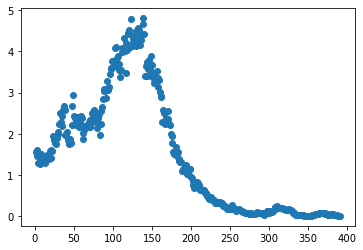

In [28]:
plt.scatter(np.arange(1,len(Ampsse8)+1,1),np.array(Ampsse8)**2)    ## d = 34cm ,, center of yoke = 30cm

In [31]:
## total d = 92.4/5cm 

In [34]:
Ampsse9,Phasesse9,errAse9,errPse9 = move_motor(400)  ## centre = 30cm, d=74cm 

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

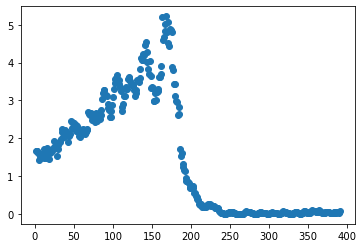

In [35]:
plt.scatter(np.arange(1,len(Ampsse9)+1,1),np.array(Ampsse9)**2)    ## d = 34cm ,, center of yoke = 30cm

In [37]:
runse9 = dict(amp = Ampsse9,phase =Phasesse9,errA =errAse9,errP = errPse9)

runse9_df= pd.DataFrame.from_dict(runse9)
runse9_df.to_csv(directory_se+'/run_se9.csv',index = False)

In [40]:
Ampsse10,Phasesse10,errAse10,errPse10 = move_motor(800)  ## centre = 30cm, d=74cm 

250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4250.0
4500.0
4750.0
5000.0
5250.0
5500.0
5750.0
6000.0
6250.0
6500.0
6750.0
7000.0
7250.0
7500.0
7750.0
8000.0
8250.0
8500.0
8750.0
9000.0
9250.0
9500.0
9750.0
10000.0
10250.0
10500.0
10750.0
11000.0
11250.0
11500.0
11750.0
12000.0
12250.0
12500.0
12750.0
13000.0
13250.0
13500.0
13750.0
14000.0
14250.0
14500.0
14750.0
15000.0
15250.0
15500.0
15750.0
16000.0
16250.0
16500.0
16750.0
17000.0
17250.0
17500.0
17750.0
18000.0
18250.0
18500.0
18750.0
19000.0
19250.0
19500.0
19750.0
20000.0
20250.0
20500.0
20750.0
21000.0
21250.0
21500.0
21750.0
22000.0
22250.0
22500.0
22750.0
23000.0
23250.0
23500.0
23750.0
24000.0
24250.0
24500.0
24750.0
25000.0
25250.0
25500.0
25750.0
26000.0
26250.0
26500.0
26750.0
27000.0
27250.0
27500.0
27750.0
28000.0
28250.0
28500.0
28750.0
29000.0
29250.0
29500.0
29750.0
30000.0
30250.0
30500.0
30750.0
31000.0
31250.0
31500.0
31750.0
32000.0
32250.0
32500.0
32

In [41]:
runse10 = dict(amp = Ampsse10,phase =Phasesse10,errA =errAse10,errP = errPse10)

runse10_df= pd.DataFrame.from_dict(runse10)
runse10_df.to_csv(directory_se+'/run_se10.csv',index = False)

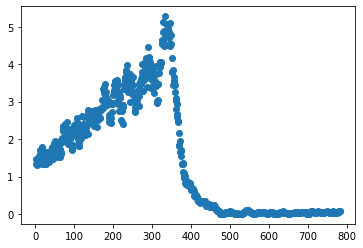

In [44]:
plt.scatter(np.arange(1,len(Ampsse10)+1,1),np.array(Ampsse10)**2)    ## d = 34cm ,, center of yoke = 30cm

   ## Section 2.3 - Single slit

In [29]:
directory_ss = r'C:\Users\Student\Documents\Student\single_slit'

In [72]:
Ampsss1,Phasesss1,errAss1,errPss1 = move_motor(400)  ## centre = , d=74cm 

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [80]:
runss1 = dict(amp = Ampsss1,phase =Phasesss1,errA =errAss1,errP = errPss1)

runss1_df= pd.DataFrame.from_dict(runss1)
runss1_df.to_csv(directory_ss+'/run_ss1.csv',index = False)

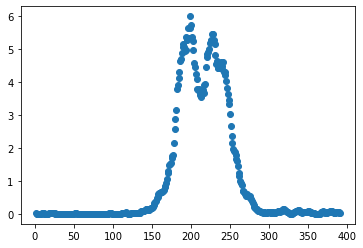

In [74]:
plt.scatter(np.arange(1,len(Ampsss1)+1,1),np.array(Ampsss1)**2)    ## d = 74cm 

In [81]:
Ampsss2,Phasesss2,errAss2,errPss2 = move_motor(800)  ## centre = , d=74cm 

250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4250.0
4500.0
4750.0
5000.0
5250.0
5500.0
5750.0
6000.0
6250.0
6500.0
6750.0
7000.0
7250.0
7500.0
7750.0
8000.0
8250.0
8500.0
8750.0
9000.0
9250.0
9500.0
9750.0
10000.0
10250.0
10500.0
10750.0
11000.0
11250.0
11500.0
11750.0
12000.0
12250.0
12500.0
12750.0
13000.0
13250.0
13500.0
13750.0
14000.0
14250.0
14500.0
14750.0
15000.0
15250.0
15500.0
15750.0
16000.0
16250.0
16500.0
16750.0
17000.0
17250.0
17500.0
17750.0
18000.0
18250.0
18500.0
18750.0
19000.0
19250.0
19500.0
19750.0
20000.0
20250.0
20500.0
20750.0
21000.0
21250.0
21500.0
21750.0
22000.0
22250.0
22500.0
22750.0
23000.0
23250.0
23500.0
23750.0
24000.0
24250.0
24500.0
24750.0
25000.0
25250.0
25500.0
25750.0
26000.0
26250.0
26500.0
26750.0
27000.0
27250.0
27500.0
27750.0
28000.0
28250.0
28500.0
28750.0
29000.0
29250.0
29500.0
29750.0
30000.0
30250.0
30500.0
30750.0
31000.0
31250.0
31500.0
31750.0
32000.0
32250.0
32500.0
32

In [82]:
runss2 = dict(amp = Ampsss2,phase =Phasesss2,errA =errAss2,errP = errPss2)

runss2_df= pd.DataFrame.from_dict(runss2)
runss2_df.to_csv(directory_ss+'/run_ss2.csv',index = False)

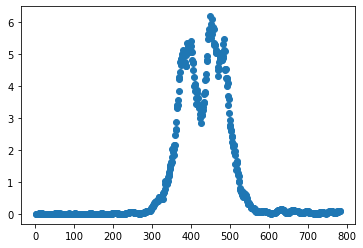

In [97]:
#plt.scatter(np.arange(1,len(Ampsss3)+1,1),np.array(Ampsss3)**2)    ## d = 75cm // d = distance from source to slit
plt.scatter(np.arange(1,len(Ampsss2)+1,1),np.array(Ampsss2)**2)    ## d = 75cm // d = distance from source to slit

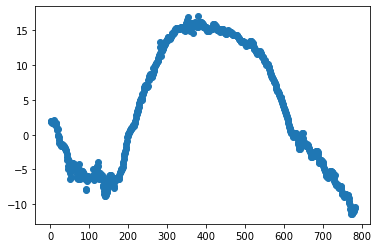

In [99]:
plt.scatter(np.arange(1,len(Phasesss3)+1,1),np.unwrap(Phasesss3,period=np.pi))    ## d = 75cm // d = distance from source to slit

In [28]:
## move back to 0 position
motor.send("initialise()")
print(motor.receive_reply(1000))

Initialising


In [93]:
Ampsss3,Phasesss3,errAss3,errPss3 = move_motor(800)  ## centre = , d=75cm 

250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4250.0
4500.0
4750.0
5000.0
5250.0
5500.0
5750.0
6000.0
6250.0
6500.0
6750.0
7000.0
7250.0
7500.0
7750.0
8000.0
8250.0
8500.0
8750.0
9000.0
9250.0
9500.0
9750.0
10000.0
10250.0
10500.0
10750.0
11000.0
11250.0
11500.0
11750.0
12000.0
12250.0
12500.0
12750.0
13000.0
13250.0
13500.0
13750.0
14000.0
14250.0
14500.0
14750.0
15000.0
15250.0
15500.0
15750.0
16000.0
16250.0
16500.0
16750.0
17000.0
17250.0
17500.0
17750.0
18000.0
18250.0
18500.0
18750.0
19000.0
19250.0
19500.0
19750.0
20000.0
20250.0
20500.0
20750.0
21000.0
21250.0
21500.0
21750.0
22000.0
22250.0
22500.0
22750.0
23000.0
23250.0
23500.0
23750.0
24000.0
24250.0
24500.0
24750.0
25000.0
25250.0
25500.0
25750.0
26000.0
26250.0
26500.0
26750.0
27000.0
27250.0
27500.0
27750.0
28000.0
28250.0
28500.0
28750.0
29000.0
29250.0
29500.0
29750.0
30000.0
30250.0
30500.0
30750.0
31000.0
31250.0
31500.0
31750.0
32000.0
32250.0
32500.0
32

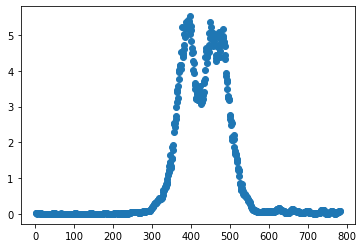

In [95]:
plt.scatter(np.arange(1,len(Ampsss3)+1,1),np.array(Ampsss3)**2)    ## d = 75cm // d = distance from source to slit

In [98]:
runss3 = dict(amp = Ampsss3,phase =Phasesss3,errA =errAss3,errP = errPss3)

runss3_df= pd.DataFrame.from_dict(runss3)
runss3_df.to_csv(directory_ss+'/run_ss3.csv',index = False)

## 2.4 - Complementary aperture

In [106]:
Ampsc4,Phasesc4,errAc4,errPc4 = move_motor(400)  ## centre = , d=75cm 

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

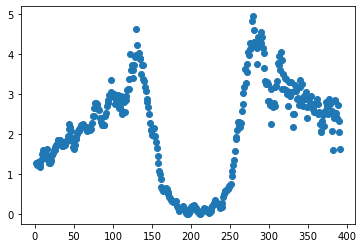

In [107]:
plt.scatter(np.arange(1,len(Ampsc4)+1,1),np.array(Ampsc4)**2)    ## d = 75cm // d = distance from source to slit

In [110]:
runsc4 = dict(amp = Ampsc4,phase =Phasesc4,errA =errAc4,errP = errPc4)

runsc4_df= pd.DataFrame.from_dict(runsc4)
runsc4_df.to_csv(directory_ss+'/runsc4.csv',index = False)

In [113]:
Ampsc5,Phasesc5,errAc5,errPc5 = move_motor(800)  ## centre = , d=75cm 

250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4250.0
4500.0
4750.0
5000.0
5250.0
5500.0
5750.0
6000.0
6250.0
6500.0
6750.0
7000.0
7250.0
7500.0
7750.0
8000.0
8250.0
8500.0
8750.0
9000.0
9250.0
9500.0
9750.0
10000.0
10250.0
10500.0
10750.0
11000.0
11250.0
11500.0
11750.0
12000.0
12250.0
12500.0
12750.0
13000.0
13250.0
13500.0
13750.0
14000.0
14250.0
14500.0
14750.0
15000.0
15250.0
15500.0
15750.0
16000.0
16250.0
16500.0
16750.0
17000.0
17250.0
17500.0
17750.0
18000.0
18250.0
18500.0
18750.0
19000.0
19250.0
19500.0
19750.0
20000.0
20250.0
20500.0
20750.0
21000.0
21250.0
21500.0
21750.0
22000.0
22250.0
22500.0
22750.0
23000.0
23250.0
23500.0
23750.0
24000.0
24250.0
24500.0
24750.0
25000.0
25250.0
25500.0
25750.0
26000.0
26250.0
26500.0
26750.0
27000.0
27250.0
27500.0
27750.0
28000.0
28250.0
28500.0
28750.0
29000.0
29250.0
29500.0
29750.0
30000.0
30250.0
30500.0
30750.0
31000.0
31250.0
31500.0
31750.0
32000.0
32250.0
32500.0
32

In [114]:
runsc5 = dict(amp = Ampsc5,phase =Phasesc5,errA =errAc5,errP = errPc5)

runsc5_df= pd.DataFrame.from_dict(runsc5)
runsc5_df.to_csv(directory_ss+'/runsc5.csv',index = False)

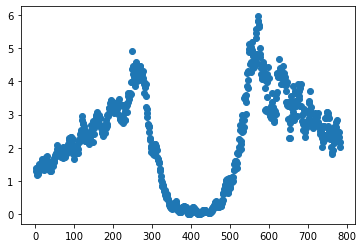

In [115]:
plt.scatter(np.arange(1,len(Ampsc5)+1,1),np.array(Ampsc5)**2)    ## d = 75cm // d = distance from source to slit

In [122]:
Ampsc6,Phasesc6,errAc6,errPc6 = move_motor(800)  ## centre = , d=75cm 

250.0
500.0
750.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4250.0
4500.0
4750.0
5000.0
5250.0
5500.0
5750.0
6000.0
6250.0
6500.0
6750.0
7000.0
7250.0
7500.0
7750.0
8000.0
8250.0
8500.0
8750.0
9000.0
9250.0
9500.0
9750.0
10000.0
10250.0
10500.0
10750.0
11000.0
11250.0
11500.0
11750.0
12000.0
12250.0
12500.0
12750.0
13000.0
13250.0
13500.0
13750.0
14000.0
14250.0
14500.0
14750.0
15000.0
15250.0
15500.0
15750.0
16000.0
16250.0
16500.0
16750.0
17000.0
17250.0
17500.0
17750.0
18000.0
18250.0
18500.0
18750.0
19000.0
19250.0
19500.0
19750.0
20000.0
20250.0
20500.0
20750.0
21000.0
21250.0
21500.0
21750.0
22000.0
22250.0
22500.0
22750.0
23000.0
23250.0
23500.0
23750.0
24000.0
24250.0
24500.0
24750.0
25000.0
25250.0
25500.0
25750.0
26000.0
26250.0
26500.0
26750.0
27000.0
27250.0
27500.0
27750.0
28000.0
28250.0
28500.0
28750.0
29000.0
29250.0
29500.0
29750.0
30000.0
30250.0
30500.0
30750.0
31000.0
31250.0
31500.0
31750.0
32000.0
32250.0
32500.0
32

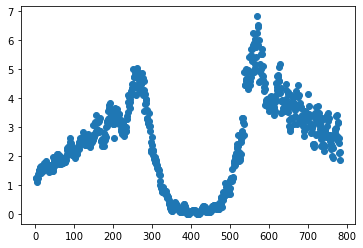

In [123]:
plt.scatter(np.arange(1,len(Ampsc6)+1,1),np.array(Ampsc6)**2)    ## d = 75cm // d = distance from source to slit // width slit =10cm

In [124]:
runsc6 = dict(amp = Ampsc6,phase =Phasesc6,errA =errAc6,errP = errPc6)

runsc6_df= pd.DataFrame.from_dict(runsc6)
runsc6_df.to_csv(directory_ss+'/runsc6.csv',index = False)

## Section 2.5 - circular aperture

In [128]:
Ampcir1,Phasescir1,errAcir1,errPcir1 = move_motor(400)  ## centre = , d=75cm 

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

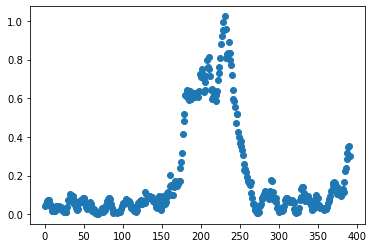

In [129]:
plt.scatter(np.arange(1,len(Ampcir1)+1,1),np.array(Ampcir1)**2)    ## d =  // d = distance from source to slit //

In [132]:
runcir1 = dict(amp = Ampcir1,phase =Phasescir1,errA =errAcir1,errP = errPcir1)

runcir1_df= pd.DataFrame.from_dict(runcir1)
runcir1_df.to_csv(directory_ss+'/runcir1.csv',index = False)

In [19]:
Ampcir2,Phasescir2,errAcir2,errPcir2 = move_motor(400)  ## centre = , d=75cm 

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

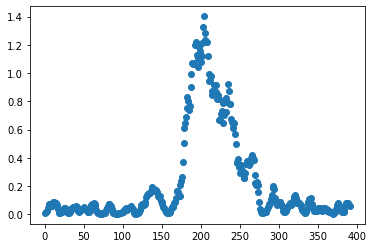

In [23]:
plt.scatter(np.arange(1,len(Ampcir2)+1,1),np.array(Ampcir2)**2)    ## d =  // d = distance from source to slit //
#plt.scatter(np.arange(1,len(Ampcir1)+1,1),np.array(Ampcir1)**2)    ## d =  // d = distance from source to slit //

In [26]:
Ampcir3,Phasescir3,errAcir3,errPcir3 = move_motor(400)  ## centre = , d=75cm 

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [30]:
runcir2 = dict(amp = Ampcir2,phase =Phasescir2,errA =errAcir2,errP = errPcir2)

runcir2_df= pd.DataFrame.from_dict(runcir2)
runcir2_df.to_csv(directory_ss+'/runcir2.csv',index = False)

In [31]:
runcir3 = dict(amp = Ampcir3,phase =Phasescir3,errA =errAcir3,errP = errPcir3)

runcir3_df= pd.DataFrame.from_dict(runcir3)
runcir3_df.to_csv(directory_ss+'/runcir3.csv',index = False)

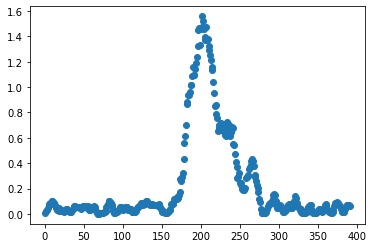

In [32]:
plt.scatter(np.arange(1,len(Ampcir3)+1,1),np.array(Ampcir3)**2)    ## d =  // d = distance from source to slit //

# SECTION 4 - Retake data with different phase unwrapping method

In [76]:
## move back to 0 position
motor.send("initialise()")
print(motor.receive_reply(1000))

Initialising


In [22]:
directory_se_new = r'C:\Users\Student\Documents\Student\new_straight_edge'

In [90]:
Amps_senew1,Phases_senew1,errAs_senew1,errPs_senew1 = move_motor(400)  ##  d=65cm  (disregard?)

500
500.0
1000
1000.0
1500
1500.0
2000
2000.0
2500
2500.0
3000
3000.0
3500
3500.0
4000
4000.0
4500
4500.0
5000
5000.0
5500
5500.0
6000
6000.0
6500
6500.0
7000
7000.0
7500
7500.0
8000
8000.0
8500
8500.0
9000
9000.0
9500
9500.0
10000
10000.0
10500
10500.0
11000
11000.0
11500
11500.0
12000
12000.0
12500
12500.0
13000
13000.0
13500
13500.0
14000
14000.0
14500
14500.0
15000
15000.0
15500
15500.0
16000
16000.0
16500
16500.0
17000
17000.0
17500
17500.0
18000
18000.0
18500
18500.0
19000
19000.0
19500
19500.0
20000
20000.0
20500
20500.0
21000
21000.0
21500
21500.0
22000
22000.0
22500
22500.0
23000
23000.0
23500
23500.0
24000
24000.0
24500
24500.0
25000
25000.0
25500
25500.0
26000
26000.0
26500
26500.0
27000
27000.0
27500
27500.0
28000
28000.0
28500
28500.0
29000
29000.0
29500
29500.0
30000
30000.0
30500
30500.0
31000
31000.0
31500
31500.0
32000
32000.0
32500
32500.0
33000
33000.0
33500
33500.0
34000
34000.0
34500
34500.0
35000
35000.0
35500
35500.0
36000
36000.0
36500
36500.0
37000
37000.0
3750

In [94]:
run_senew1 = dict(amp = Amps_senew1,phase =Phases_senew1[1:],errA =errAs_senew1,errP = errPs_senew1)

run_senew1_df= pd.DataFrame.from_dict(run_senew1)
run_senew1_df.to_csv(directory_se_new+'/run1.csv',index = False)

In [100]:
Amps_senew2,Phases_senew2,errAs_senew2,errPs_senew2 = move_motor(400)  ##  d=39.3 

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [103]:
run_senew2 = dict(amp = Amps_senew2,phase =Phases_senew2[1:],errA =errAs_senew2,errP = errPs_senew2)

run_senew2_df= pd.DataFrame.from_dict(run_senew2)
run_senew2_df.to_csv(directory_se_new+'/run2.csv',index = False)

In [111]:
Amps_senew3,Phases_senew3,errAs_senew3,errPs_senew3 = move_motor(400)  ##  d=39.3 

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [112]:
run_senew3 = dict(amp = Amps_senew3,phase =Phases_senew3[1:],errA =errAs_senew3,errP = errPs_senew3)

run_senew3_df= pd.DataFrame.from_dict(run_senew3)
run_senew3_df.to_csv(directory_se_new+'/run3.csv',index = False)

In [116]:
Amps_senew4,Phases_senew4,errAs_senew4,errPs_senew4 = move_motor(400)  ##  d == 39.3

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [117]:
run_senew4 = dict(amp = Amps_senew4,phase =Phases_senew4[1:],errA =errAs_senew4,errP = errPs_senew4)

run_senew4_df= pd.DataFrame.from_dict(run_senew4)
run_senew4_df.to_csv(directory_se_new+'/run4.csv',index = False)

In [122]:
Amps_senew5,Phases_senew5,errAs_senew5,errPs_senew5 = move_motor(400)  ##  d == 14

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [123]:
run_senew5 = dict(amp = Amps_senew5,phase =Phases_senew5[1:],errA =errAs_senew5,errP = errPs_senew5)

run_senew5_df= pd.DataFrame.from_dict(run_senew5)
run_senew5_df.to_csv(directory_se_new+'/run5.csv',index = False)

In [126]:
Amps_senew6,Phases_senew6,errAs_senew6,errPs_senew6 = move_motor(400)  ##  d == 14

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [127]:
run_senew6 = dict(amp = Amps_senew6,phase =Phases_senew6[1:],errA =errAs_senew6,errP = errPs_senew6)

run_senew6_df= pd.DataFrame.from_dict(run_senew6)
run_senew6_df.to_csv(directory_se_new+'/run6.csv',index = False)

In [130]:
Amps_senew7,Phases_senew7,errAs_senew7,errPs_senew7 = move_motor(400)  ##  d == 14

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [131]:
run_senew7 = dict(amp = Amps_senew7,phase =Phases_senew7[1:],errA =errAs_senew7,errP = errPs_senew7)

run_senew7_df= pd.DataFrame.from_dict(run_senew7)
run_senew7_df.to_csv(directory_se_new+'/run7.csv',index = False)

In [133]:
Amps_senewBG,Phases_senewBG,errAs_senewBG,errPs_senewBG = move_motor(400)  ##  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [134]:
run_senewBG = dict(amp = Amps_senewBG,phase =Phases_senewBG[1:],errA =errAs_senewBG,errP = errPs_senewBG)

run_senewBG_df= pd.DataFrame.from_dict(run_senewBG)
run_senewBG_df.to_csv(directory_se_new+'/runBG.csv',index = False)

In [136]:
Amps_senew8,Phases_senew8,errAs_senew8,errPs_senew8 = move_motor(400)  ##  67.5

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [137]:
run_senew8 = dict(amp = Amps_senew8,phase =Phases_senew8[1:],errA =errAs_senew8,errP = errPs_senew8)

run_senew8_df= pd.DataFrame.from_dict(run_senew8)
run_senew8_df.to_csv(directory_se_new+'/run8.csv',index = False)

In [139]:
Amps_senew9,Phases_senew9,errAs_senew9,errPs_senew9 = move_motor(400)  ##  67.5

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [141]:
run_senew9 = dict(amp = Amps_senew9,phase =Phases_senew9[1:],errA =errAs_senew9,errP = errPs_senew9)

run_senew9_df= pd.DataFrame.from_dict(run_senew9)
run_senew9_df.to_csv(directory_se_new+'/run9.csv',index = False)

In [142]:
Amps_senew10,Phases_senew10,errAs_senew10,errPs_senew10 = move_motor(400)  ##  67.5

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [143]:
run_senew10 = dict(amp = Amps_senew10,phase =Phases_senew10[1:],errA =errAs_senew10,errP = errPs_senew10)

run_senew10_df= pd.DataFrame.from_dict(run_senew10)
run_senew10_df.to_csv(directory_se_new+'/run10.csv',index = False)

In [147]:
Amps_senew11,Phases_senew11,errAs_senew11,errPs_senew11 = move_motor(400)  ##  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [148]:
run_senew11 = dict(amp = Amps_senew11,phase =Phases_senew11[1:],errA =errAs_senew11,errP = errPs_senew11)

run_senew11_df= pd.DataFrame.from_dict(run_senew11)
run_senew11_df.to_csv(directory_se_new+'/run11.csv',index = False)

In [152]:
Amps_senew12,Phases_senew12,errAs_senew12,errPs_senew12 = move_motor(400)  ##  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [153]:
run_senew12 = dict(amp = Amps_senew12,phase =Phases_senew12[1:],errA =errAs_senew12,errP = errPs_senew12)

run_senew12_df= pd.DataFrame.from_dict(run_senew12)
run_senew12_df.to_csv(directory_se_new+'/run12.csv',index = False)

In [155]:
Amps_senew13,Phases_senew13,errAs_senew13,errPs_senew13 = move_motor(400)  ##  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [156]:
run_senew13 = dict(amp = Amps_senew13,phase =Phases_senew13[1:],errA =errAs_senew13,errP = errPs_senew13)

run_senew13_df= pd.DataFrame.from_dict(run_senew13)
run_senew13_df.to_csv(directory_se_new+'/run13.csv',index = False)

In [19]:
Amps_senewBG2,Phases_senewBG2,errAs_senewBG2,errPs_senewBG2 = move_motor(400)  ##  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [23]:
run_senewBG2 = dict(amp = Amps_senewBG2,phase =Phases_senewBG2[1:],errA =errAs_senewBG2,errP = errPs_senewBG2)

run_senewBG2_df= pd.DataFrame.from_dict(run_senewBG2)
run_senewBG2_df.to_csv(directory_se_new+'/runBG2.csv',index = False)

In [27]:
Amps_senewBG3,Phases_senewBG3,errAs_senewBG3,errPs_senewBG3 = move_motor(400)  ##  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [28]:
run_senewBG3 = dict(amp = Amps_senewBG3,phase =Phases_senewBG3[1:],errA =errAs_senewBG3,errP = errPs_senewBG3)

run_senewBG3_df= pd.DataFrame.from_dict(run_senewBG3)
run_senewBG3_df.to_csv(directory_se_new+'/runBG3.csv',index = False)

In [30]:
## single slits

In [31]:
Amps_ssnew1,Phasss_ssnew1,errAs_ssnew1,errPs_ssnew1 = move_motor(400)  ##  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [33]:
run_ssnew1 = dict(amp = Amps_ssnew1,phass =Phasss_ssnew1[1:],errA =errAs_ssnew1,errP = errPs_ssnew1)

run_ssnew1_df= pd.DataFrame.from_dict(run_ssnew1)
run_ssnew1_df.to_csv(directory_se_new+'/run1.csv',index = False)

In [35]:
Amps_ssnew2,Phasss_ssnew2,errAs_ssnew2,errPs_ssnew2 = move_motor(400)  ##  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [38]:
run_ssnew2 = dict(amp = Amps_ssnew2,phass =Phasss_ssnew2[1:],errA =errAs_ssnew2,errP = errPs_ssnew2)

run_ssnew2_df= pd.DataFrame.from_dict(run_ssnew2)
run_ssnew2_df.to_csv(directory_se_new+'/ss_run2.csv',index = False)

In [39]:
Amps_ssnew3,Phasss_ssnew3,errAs_ssnew3,errPs_ssnew3 = move_motor(400)  ##  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [40]:
run_ssnew3 = dict(amp = Amps_ssnew3,phass =Phasss_ssnew3[1:],errA =errAs_ssnew3,errP = errPs_ssnew3)

run_ssnew3_df= pd.DataFrame.from_dict(run_ssnew3)
run_ssnew3_df.to_csv(directory_se_new+'/ss_run3.csv',index = False)

In [42]:
Amps_scnew1,Phassc_scnew1,errAs_scnew1,errPs_scnew1 = move_motor(400)  ##  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [45]:
run_scnew1 = dict(amp = Amps_scnew1,phasc =Phassc_scnew1[1:],errA =errAs_scnew1,errP = errPs_scnew1)

run_scnew1_df= pd.DataFrame.from_dict(run_scnew1)
run_scnew1_df.to_csv(directory_se_new+'/sc_run1.csv',index = False)

In [46]:
Amps_scnew2,Phassc_scnew2,errAs_scnew2,errPs_scnew2 = move_motor(400)  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [49]:
run_scnew2 = dict(amp = Amps_scnew2,phasc =Phassc_scnew2[1:],errA =errAs_scnew2,errP = errPs_scnew2)

run_scnew2_df= pd.DataFrame.from_dict(run_scnew2)
run_scnew2_df.to_csv(directory_se_new+'/sc_run2.csv',index = False)

In [53]:
Amps_scnew3,Phassc_scnew3,errAs_scnew3,errPs_scnew3 = move_motor(400)  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [54]:
run_scnew3 = dict(amp = Amps_scnew3,phasc =Phassc_scnew3[1:],errA =errAs_scnew3,errP = errPs_scnew3)

run_scnew3_df= pd.DataFrame.from_dict(run_scnew3)
run_scnew3_df.to_csv(directory_se_new+'/sc_run3.csv',index = False)

In [56]:
Amps_cirnew1,Phassc_cirnew1,errAs_cirnew1,errPs_cirnew1 = move_motor(400)  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [58]:
run_cirnew1 = dict(amp = Amps_cirnew1,phasc =Phassc_cirnew1[1:],errA =errAs_cirnew1,errP = errPs_cirnew1)

run_cirnew1_df= pd.DataFrame.from_dict(run_cirnew1)
run_cirnew1_df.to_csv(directory_se_new+'/cir_run1.csv',index = False)

In [59]:
Amps_cirnew2,Phassc_cirnew2,errAs_cirnew2,errPs_cirnew2 = move_motor(400)  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [71]:
## move back to 0 position
motor.send("initialise()")
print(motor.receive_reply(1000))

Initialising


In [62]:
run_cirnew2 = dict(amp = Amps_cirnew2,phasc =Phassc_cirnew2[1:],errA =errAs_cirnew2,errP = errPs_cirnew2)

run_cirnew2_df= pd.DataFrame.from_dict(run_cirnew2)
run_cirnew2_df.to_csv(directory_se_new+'/cir_run2.csv',index = False)

In [63]:
Amps_cirnew3,Phassc_cirnew3,errAs_cirnew3,errPs_cirnew3 = move_motor(400)  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [64]:
run_cirnew3 = dict(amp = Amps_cirnew3,phasc =Phassc_cirnew3[1:],errA =errAs_cirnew3,errP = errPs_cirnew3)

run_cirnew3_df= pd.DataFrame.from_dict(run_cirnew3)
run_cirnew3_df.to_csv(directory_se_new+'/cir_run3.csv',index = False)

In [66]:
Amps_circnew1,Phassc_circnew1,errAs_circnew1,errPs_circnew1 = move_motor(400)  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [67]:
run_circnew1 = dict(amp = Amps_circnew1,phasc =Phassc_circnew1[1:],errA =errAs_circnew1,errP = errPs_circnew1)

run_circnew1_df= pd.DataFrame.from_dict(run_circnew1)
run_circnew1_df.to_csv(directory_se_new+'/circ_run1.csv',index = False)

In [69]:
Amps_circnew2,Phassc_circnew2,errAs_circnew2,errPs_circnew2 = move_motor(400)  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [72]:
run_circnew2 = dict(amp = Amps_circnew2,phasc =Phassc_circnew2[1:],errA =errAs_circnew2,errP = errPs_circnew2)

run_circnew2_df= pd.DataFrame.from_dict(run_circnew2)
run_circnew2_df.to_csv(directory_se_new+'/circ_run2.csv',index = False)

In [73]:
Amps_circnew3,Phassc_circnew3,errAs_circnew3,errPs_circnew3 = move_motor(400)  

500.0
1000.0
1500.0
2000.0
2500.0
3000.0
3500.0
4000.0
4500.0
5000.0
5500.0
6000.0
6500.0
7000.0
7500.0
8000.0
8500.0
9000.0
9500.0
10000.0
10500.0
11000.0
11500.0
12000.0
12500.0
13000.0
13500.0
14000.0
14500.0
15000.0
15500.0
16000.0
16500.0
17000.0
17500.0
18000.0
18500.0
19000.0
19500.0
20000.0
20500.0
21000.0
21500.0
22000.0
22500.0
23000.0
23500.0
24000.0
24500.0
25000.0
25500.0
26000.0
26500.0
27000.0
27500.0
28000.0
28500.0
29000.0
29500.0
30000.0
30500.0
31000.0
31500.0
32000.0
32500.0
33000.0
33500.0
34000.0
34500.0
35000.0
35500.0
36000.0
36500.0
37000.0
37500.0
38000.0
38500.0
39000.0
39500.0
40000.0
40500.0
41000.0
41500.0
42000.0
42500.0
43000.0
43500.0
44000.0
44500.0
45000.0
45500.0
46000.0
46500.0
47000.0
47500.0
48000.0
48500.0
49000.0
49500.0
50000.0
50500.0
51000.0
51500.0
52000.0
52500.0
53000.0
53500.0
54000.0
54500.0
55000.0
55500.0
56000.0
56500.0
57000.0
57500.0
58000.0
58500.0
59000.0
59500.0
60000.0
60500.0
61000.0
61500.0
62000.0
62500.0
63000.0
63500.0
6400

In [75]:
run_circnew3 = dict(amp = Amps_circnew3,phasc =Phassc_circnew3[1:],errA =errAs_circnew3,errP = errPs_circnew3)

run_circnew3_df= pd.DataFrame.from_dict(run_circnew3)
run_circnew3_df.to_csv(directory_se_new+'/circ_run3.csv',index = False)